# Systemy uczące się - Zad. dom. 2: Maszyny wektorów podpierających

### Autor rozwiązania
Uzupełnij poniższe informacje umieszczając swoje imię i nazwisko oraz numer indeksu:

In [3]:
NAME = "Bartłomiej Andree"
ID = "162961"

Ten notebook zawiera zadania związane z maszynami wektorów podpierających (SVM).
Do notebooka zostały dołączony plik helpers.py oraz dwa pliki .npz z danymi, które są używane w zadaniach, 
nie musisz do nich zaglądać ani ich modyfikować. Notebook jest sprawdzany półautomatycznie - przed wysyłką sprawdź czy cały kod wykonuje się bez błędów.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Zadanie 1. - Implementacja maszyny wektorów podpierających (za 20%)

Zadanie polega na zaimplementowaniu maszyny wektorów podpierających z wykorzystaniem biblioteki [`cvxpy`](https://github.com/cvxpy/cvxpy) zapewniającej solver do programowania kwadratowego. Rozpocznijmy od szybkiej nauki jak ta biblioteka działa:


In [5]:
!pip install cvxpy

- Optymalizacja bez ograniczeń: znajdź maksimum funkcji $$ - (x - 5 )^2 + 10$$

In [6]:
from cvxpy import Variable, Maximize, Problem

x = Variable(1)  #zmienna optymalizowana, wektor o długości 1 (bo to jedna liczba)

objective = Maximize(-(x - 5) ** 2 + 10)  # Implementacja funkcji celu ze wskazanym kierunkiem maksymalizacji
prob = Problem(objective)  # Stworzenie problemu optymalizacji

print(prob.solve())  #Rozwiąż i zwróć wartość funkcji celu
print(x.value)  # Znaleziona wartość x
print(prob.status)

10.0
[5.]
optimal


- optymalizacja z ograniczeniami: znajdź minimum funkcji $e^{(x-2)^2}$ dla $x>0$.

In [7]:
from cvxpy import exp, Minimize

x = Variable(1)

objective = Minimize(exp((x - 2) ** 2))
constraints = [x >= 0]
prob = Problem(objective, constraints)  # Problem teraz składa się z funkcji celu i "listy" ograniczeń

print(prob.solve())
print(x.value)
print(prob.status)

1.0000000000000973
[2.00000031]
optimal


- optymalizacja z ograniczeniami: znajdź minimum funkcji $x + y$ dla $x\geq 0, y\geq 6$.

In [8]:
from cvxpy import Minimize

x = Variable(1)
y = Variable(1)

objective = Minimize(x + y)
constraints = [x >= 0, y >= 6]  # To zwykła pythonowa lista
prob = Problem(objective, constraints)  # Problem teraz składa się z funkcji celu i listy ograniczeń

print(prob.solve())
print(x.value, y.value)
print(prob.status)

6.000000000000001
[6.06639057e-17] [6.]
optimal


Alternatywna postać tego samego problemu, wykorzystująca notację wektorową:

In [9]:
x = Variable(2)

objective = Minimize(sum(x))
constraints = [x[0] >= 0, x[1] >= 6]
prob = Problem(objective, constraints)  # Problem teraz składa się z funkcji celu i listy ograniczeń

print(prob.solve())
print(x.value)
print(prob.status)

6.000000000000001
[6.06639057e-17 6.00000000e+00]
optimal


Wygenerujmy i narysujmy próbkę dwuwymiarowych danych, które są separowalne liniowo. Zwróć uwagę, że dla uproszczenia przyszłej implementacji każda z cech jest przechowywana w osobnym wektorze. Wektor `x` zawiera wartości pierwszej cechy, wektor `y` zawiera wartości drugiej cechy, a `labels` zawiera wartości klasy decyzyjnej.

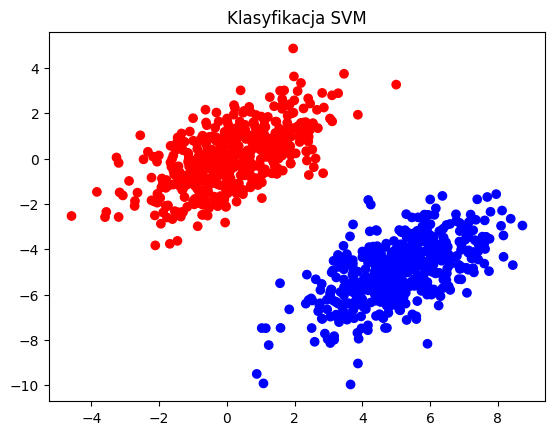

In [10]:
from helpers import plot_classification, get_separable

x, y, labels = get_separable()
plot_classification(x, y, labels)

Mamy dane pochodzące z dwóch klas, a nasze zadanie polega na implementacji klasyfikatora SVM czyli indukcji (w naszym dwuwymiarowym przypadku) linii któa będzie separowała obie klasy. 
$$a \cdot x+b \cdot y +c = 0$$
Klasyfikator będzie przypisywał obiekt do jednej z klas gdy będzie się on znajdował po prawej stronie tej linii, jeśli zaś obiekt będzie po lewej jej stronie to przypiszemy obiekt do drugiej z klas. Znajdź taką linię dla powyższych danych, gdzie `x` i `y` to współrzędne punktów, a `labels` przyjmuje wartości $1$ i $-1$ wskazując na klasę obserwacji.

In [12]:
def construct_svm_opt_problem(x: np.ndarray, y: np.ndarray, labels: np.ndarray) -> Problem:
    """Funkcja budująca problem optymalizacji dla klasyfikatora SVM (hard margin).
    
    Args:
        x (np.ndarray): Współrzędne x obiektów
        y (np.ndarray): Współrzędne y obiektów
        labels (np.ndarray): Klasy obiektów
   
    Returns:
        Problem: Obiekt problemu optymalizacyjnego dla klasyfikatora SVM
   
    """

    a, b, c = Variable(), Variable(), Variable()

    # TWÓJ KOD TUTAJ

    # Funkcja celu w SVM to minimalizacja 1/2 * ||w||^2
    # Gdzie w to wektor normalny do hiperpłaszczyzny [a, b]
    # Minimalizujemy więc 1/2 * (a^2 + b^2)
    objective = Minimize(0.5 * (a**2 + b**2))

    # Ograniczenia: każdy punkt musi być po odpowiedniej stronie hiperpłaszczyzny z marginesem co najmniej 1
    # dla klasy 1: a*x + b*y + c >= 1
    # dla klasy -1: a*x + b*y + c <= -1
    constraints = []
    for i in range(len(x)):
        # Ogólny wzór: label * (a*x + b*y + c) >= 1
        constraints.append(labels[i] * (a * x[i] + b * y[i] + c) >= 1)

    return Problem(objective, constraints)

prob = construct_svm_opt_problem(x, y, labels)
prob.solve()
prob.status

'optimal'

Jeśli dobrze wytrenowałeś klasyfikator to powinno się udać go narysować.

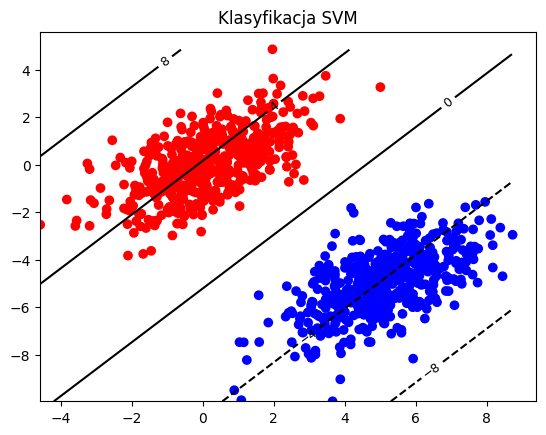

In [13]:
a, b, c = prob.variables()
plot_classification(x, y, labels, a=a.value, b=b.value, c=c.value)

Przejdźmy na trudniejszy zbiór, który nie jest liniowo separowalny. 

**UWAGA** Dane są losowane - istnieje mała szansa, że akurat wylosujesz zbiór separowalny. W takiej sytuacji powtórz wywołanie.

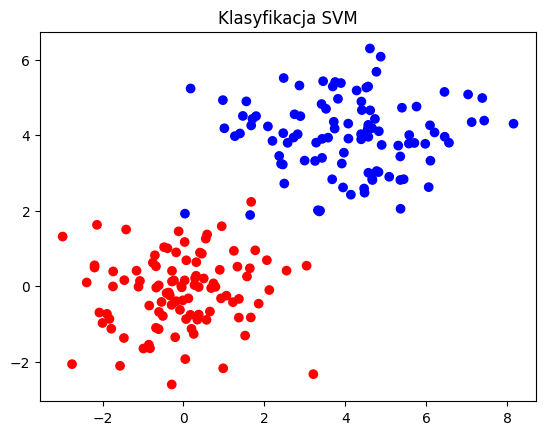

In [21]:
from helpers import plot_classification, get_non_separable

x, y, labels = get_non_separable()
plot_classification(x, y, labels)

Rozszerz swoją implementację klasyfikatora SVM tak aby prawidłowo działał również ze zbiorami nieliniowo separowalnymi. Za stałą $C$ możesz przyjąć 1.

In [22]:
def construct_softsvm_opt_problem(x: np.ndarray, y: np.ndarray, labels: np.ndarray, C: int = 1) -> Problem:
    """Funkcja budująca problem optymalizacji dla klasyfikatora SVM (soft margin).
    
    Args:
        x (np.ndarray): Współrzędne x obiektów
        y (np.ndarray): Współrzędne y obiektów
        labels (np.ndarray): Klasy obiektów
        C (int): Stała C
    
    Returns:
        Problem: Obiekt problemu optymalizacyjnego dla klasyfikatora SVM
    
    """

    a, b, c, eta = Variable(), Variable(), Variable(), Variable(len(labels))

    # TWÓJ KOD TUTAJ

    # Funkcja celu to minimalizacja normy wektora [a, b] oraz kary za błędy
    objective = Minimize(0.5 * (a**2 + b**2) + C * sum(eta))

    constraints = []

    # Dla każdego punktu definiuję ograniczenia
    for i in range(len(x)):
        constraints.append(labels[i] * (a * x[i] + b * y[i] + c) >= 1 - eta[i])
        constraints.append(eta[i] >= 0)  # eta nie może być ujemna

    return Problem(objective, constraints)

prob = construct_softsvm_opt_problem(x, y, labels)
prob.solve()
prob.status

'optimal'

Narysuj nauczony klasyfikator.

In [24]:
a, b, c, eta = prob.variables()
plot_classification(x, y, labels, a=a.value, b=b.value, c=c.value)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Zadanie 2. - Eksploracja liniowego SVM (za 20%)

Wczytaj dane liniowo sepratowalne gdzie `X` to macierz cech, a `y` zwiera wartości klasy decyzyjnej.

In [25]:
from helpers import get_separable

x, y = get_separable(True)

Wytrenuj model maszyn wektorów podpierających używając obiektu SVC (Support Vector Classifier) z biblioteki `sklearn`. Konstruktor tego obiektu ma parametr `kernel` który domyślnie jest ustawiony na jądro RBF, początkowo będziemy chcieli używać wersji klasyfikatora bez jądra czyli inaczej z jądrem liniowym - ustaw ten parametr na wartość `"linear"`.

In [27]:
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(x, y)

SVC(kernel='linear')

Kolejnym krokiem będzie narysowanie granicy decyzji. Funkcję możesz implementować przyrostowo, punkt po punkcie.
1. Niech funkcja narysuje dane uczące (x,y) zaznaczając kolorem klasy decyzyjne.
2. Zaznacz na wykresie granicę decyzji. Wytrenowany SVM (obiekt SVC) ma odpowiednie wartości nauczonych współczynników we właściwości `svm.coef_` a także wyraz wolny w `svm.intercept_`<br>
    *Wskazówka*: Zwróć uwagę, że linię separującą o wzorze
    $w_0*x_0 + w_1*x_1 + b = 0$ można przekształcić do postaci:
    $$x_1= -\frac{w_0}{w_1}  x_0 - \frac{b}{w_1} $$
3. Zaznacz na wykresie margines decyzji (np. poprzez narysowanie dwóch linii równoległych do granicy decyzji w odpowiedniej odległości). Przypomnij sobie, że z naszych wyprowadzeń wynika że wartość marginesu to $\frac{1}{||w||}$
4. Zakreśl specjalnym symbolem lub podświetl elementy zbioru uczącego będącymi wektorami podpierającymi. Ich współrzędne możesz odnaleźć we właściwości `svm.support_vectors_`

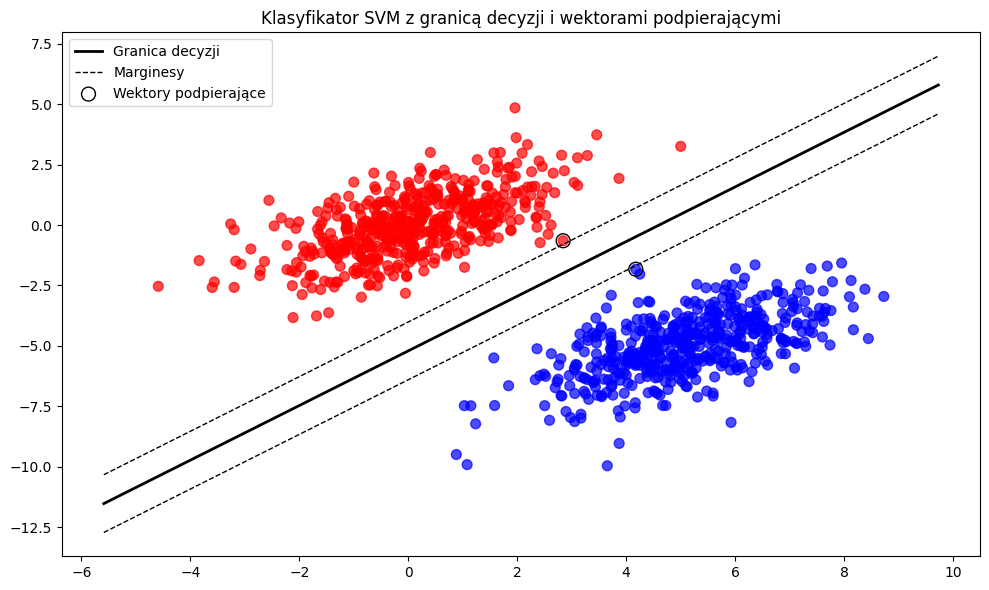

In [28]:
def plot_svm(svm: SVC, x: np.ndarray, y: np.ndarray) -> None:
    """Funkcja rysująca granicę decyzji klasyfikatora SVM.
    
    Args:
        svm (SVC): Wytrenowany klasyfikator SVM
        x (np.ndarray): Cechy
        y (np.ndarray): Klasy
    
    Returns:
        None
    """
    # TWÓJ KOD TUTAJ

    # Wielkość wykresu
    plt.figure(figsize=(10, 6))

    # Kolorowanie według klas
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', s=50, alpha=0.7)

    # Współczynniki granicy decyzji
    w = svm.coef_[0]
    b = svm.intercept_[0]

    # Wyznaczam zakres wykresu
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1

    # Rysuję granicę decyzji: w[0]*x0 + w[1]*x1 + b = 0
    # Przekształcenie do postaci x1 = -(w[0]/w[1])*x0 - b/w[1]
    if w[1] != 0:
        xx = np.linspace(x_min, x_max, 100)
        yy = -(w[0] / w[1]) * xx - (b / w[1])
        plt.plot(xx, yy, 'k-', linewidth=2, label='Granica decyzji')

        # Rysuję margines
        # Wartość marginesu to 1/||w||
        margin = 1 / np.sqrt(np.sum(w ** 2))
        yy_down = yy - margin * (1 / w[1])
        yy_up = yy + margin * (1 / w[1])
        plt.plot(xx, yy_down, 'k--', linewidth=1, label='Marginesy')
        plt.plot(xx, yy_up, 'k--', linewidth=1)

    # Zaznaczam wektory podpierające
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
               s=100, linewidth=1, facecolors='none', edgecolors='k',
               label='Wektory podpierające')

    plt.title('Klasyfikator SVM z granicą decyzji i wektorami podpierającymi')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_svm(model, x, y)

Zwróć uwagę na granicę decyzji, narysowany margines oraz podświetlone obiekty będące wektorami podpierającymi.

Wczytaj nowy zbiór danych

In [29]:
dane = np.load('data_outlier.npz')
x = dane['X']
y = dane['y'].reshape(-1)

oraz powtórz poprzednią procedurę tj. wytrenuj klasyfikator oraz narysuj wykres.

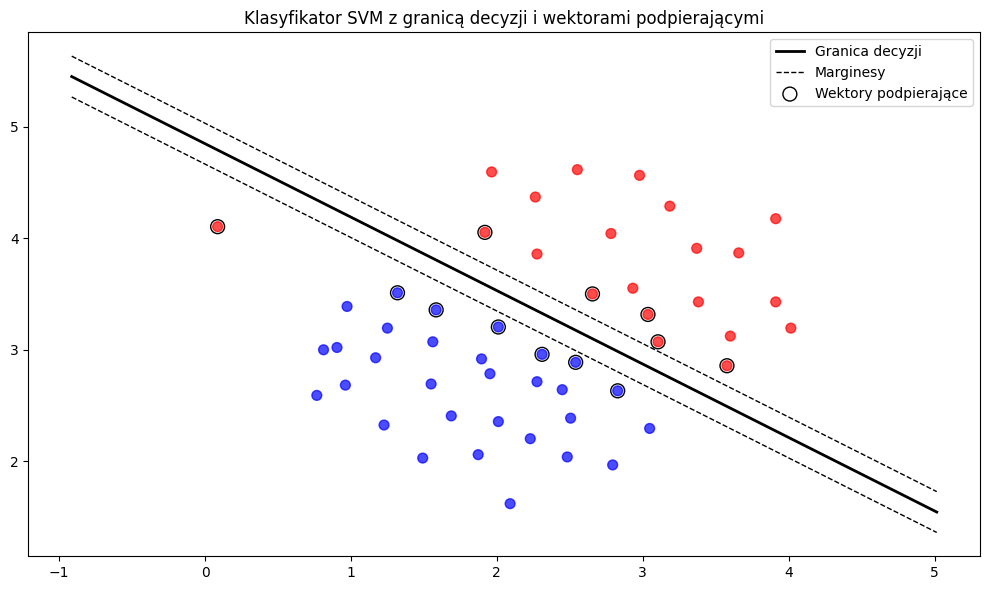

In [30]:
model = SVC(kernel='linear')
model.fit(x, y)
plot_svm(model, x, y)

W `sklearn` klasyfikator SVM ma domyślną wartość parametru $C = 1.0$. Zbiór jest jednak liniowo separowalny - sprawdź jak wygląda granica decyzji z innymi wartościami $C$ a w szczególności z wartością `C = float("inf")`. Wartość $C$ jest parametrem konstruktora obiektu SVC.

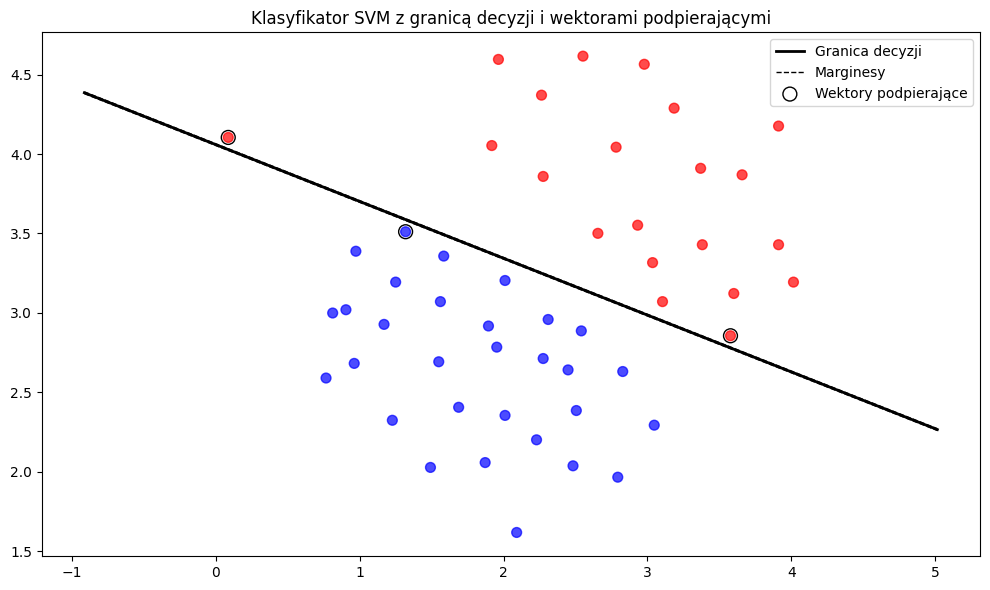

In [31]:
model = SVC(kernel='linear', C=float('inf'))
model.fit(x, y)
plot_svm(model, x, y)

Wypróbuj różne wartości parametru $C$ na zbiorze nieseparowalnym liniowo. 

In [32]:
from helpers import get_non_separable

x, y = get_non_separable(True)

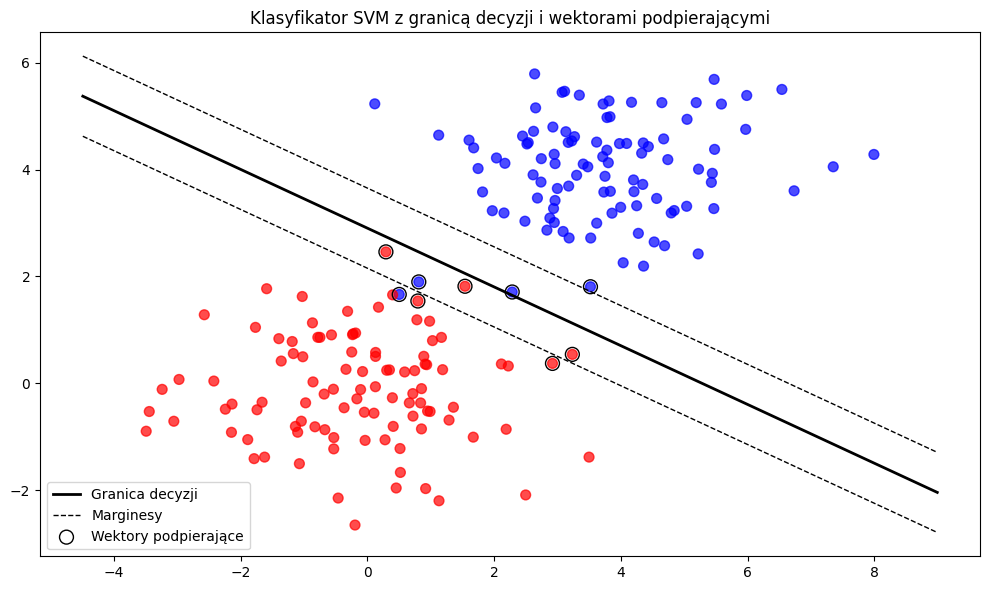

In [33]:
model = SVC(kernel='linear', C=1)
model.fit(x, y)
plot_svm(model, x, y)

**Polecenia**
1. Jak zmienia się wyindukowana granica decyzji dla bardzo dużych ($\infty$) i bardzo małych (np. 0.01) wartości $C$? Jak zmienia się trafność klasyfikatora na zbiorze uczącym? Jak sądzisz, która granica decyzja będzie najlepsza na zbiorze testowym?
2. Jak zmienia się liczba wektorów podpierających wraz ze zmianą $C$? Liczba wektorów podpierających jest miarą złożoności hipotezy - jakie wartości $C$ powodują bardziej złożone hipotezy? Odnieś te rozważania do przetargu wariancja - obciążenie.
3. Czy klasyfikator SVM jest klasyfikatorem który może zwrócić prawdopodobieństwo przynależności do klas? Czy jest to klasyfikator generatywny czy dyskryminacyjny?

Odpowiedz na powyższe pytania:

# 1

- Dla bardzo dużych wartości C (nieskończoność) granica decyzji stara się idealnie dopasować do wszystkich punktów treningowych. Margines jest wtedy wąski, a granica może mieć nieregularny kształt, zwłaszcza gdy w danych są punkty odstające. Trafność na zbiorze uczącym jest wtedy bardzo wysoka, praktycznie 100%, ponieważ model za wszelką cenę stara się prawidłowo sklasyfikować każdy punkt.

- Z kolei dla bardzo małych wartości C (0.01) granica decyzji jest znacznie bardziej wygładzona i regularna. Model nie zwraca uwagi na pojedyncze trudne przypadki czy outlinery, co skutkuje szerszym marginesem. Oczywiście trafność na zbiorze uczącym spada, bo więcej punktów zostaje niepoprawnie sklasyfikowanych, ale granica lepiej odzwierciedla ogólną strukturę danych.

- Moim zdaniem najlepszą granicą decyzji na zbiorze testowym będzie ta dla pośrednich wartości C (między 0.1 a 10). Zbyt małe C da zbyt prosty model, który pominie istotne wzorce w danych. Z drugiej strony, zbyt duże C spowoduje nadmierne dopasowanie do szczegółów zbioru uczącego (overfitting), co skutkuje słabą generalizacją na nowe dane. Optymalna wartość C powinna zapewniać dobrą równowagę między dopasowaniem do danych a zdolnością generalizacji.

# 2

- Dla małych wartości C (np. 0.01) liczba wektorów podpierających jest większa. W miarę zwiększania C ta liczba maleje. Jest to zgodne z teorią, ponieważ mały parametr C oznacza większą tolerancję na błędy klasyfikacji, przez co więcej punktów znajduje się w okolicy marginesu i staje się wektorami podpierającymi.

- Z punktu widzenia kompromisu między wariancją a obciążeniem, małe wartości C prowadzą do modeli o większym obciążeniu i mniejszej wariancji. Taki model ma prostszą granicę decyzji (mniej dopasowaną do danych), co może skutkować niedopasowaniem. Natomiast duże wartości C generują modele o mniejszym obciążeniu i większej wariancji - granica decyzji jest bardziej skomplikowana, lepiej dopasowana do danych treningowych, ale może gorzej generalizować na nowe dane.

# 3

- SVM w swojej podstawowej formie nie zwraca prawdopodobieństw przynależności do klas - zwraca jedynie decyzję o przypisaniu do konkretnej klasy. Klasyfikator podejmuje decyzję na podstawie odległości od hiperpłaszczyzny, a nie na podstawie rozkładu prawdopodobieństwa.

- SVM jest klasyfikatorem dyskryminacyjnym, ponieważ modeluje bezpośrednio granicę decyzji między klasami (P(y|x)), a nie rozkład cech w obrębie poszczególnych klas (P(x|y)). SVM skupia się wyłącznie na znalezieniu optymalnej hiperpłaszczyzny separującej klasy i nie modeluje pełnego rozkładu prawdopodobieństwa w przestrzeni cech.

## Zadanie 3. - Trik jądrowy (za 20%)
Klasyfikator SVM, który jest liniowy jest dość mocno ograniczony. Nie będzie potrafił m.in. prawidłowo zaklasyfikować przedstawionego zbioru.

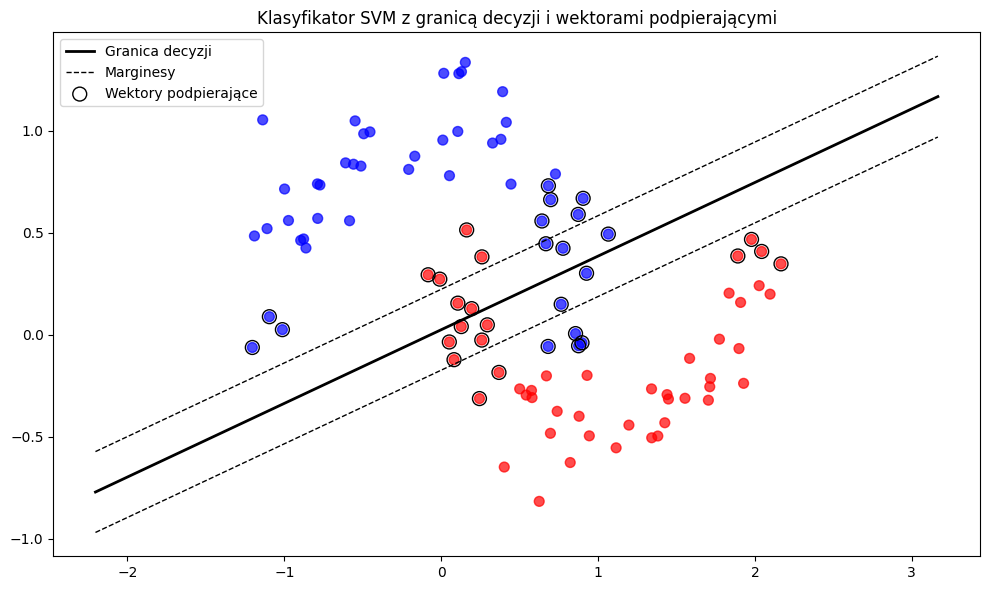

In [34]:
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, noise=0.15, random_state=2024)

model = SVC(kernel="linear")
model.fit(x, y)
plot_svm(model, x, y)

Problem ten można rozwiązać podobnie jak w przypadku regresji logistycznej: poprzez dodawanie dodatkowych cech. Na zajęciach z regresji dodawaliśmy cechy wielomianowe: spróbuj tego tricku również teraz wykorzystując obiekt `Pipeline` oraz `PolynomialFeatures` z cechami stopnia 3. 

**Uwaga**: do rysowania wykresu trzeba teraz użyć funkcji `plot_classifier`.

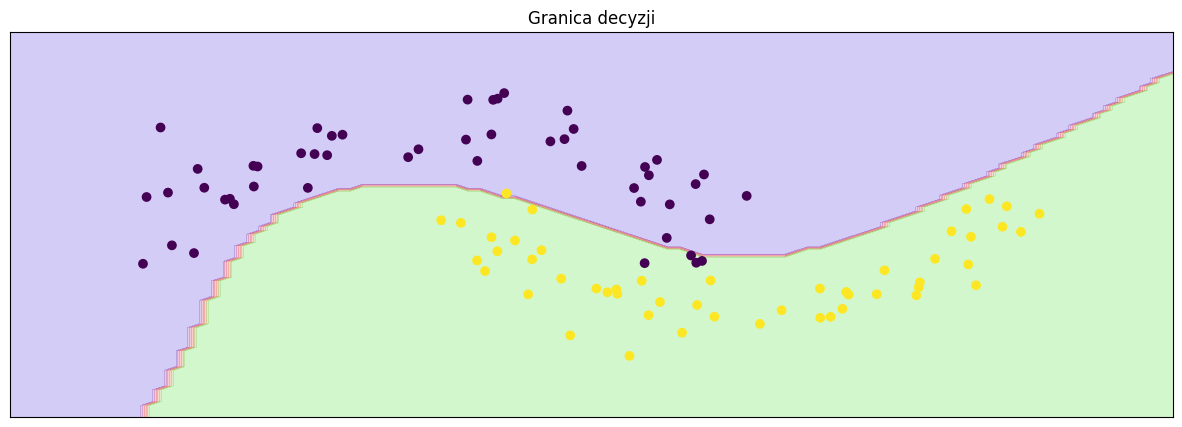

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from helpers import plot_classifier

pipeline = Pipeline([
    ('cubic features', PolynomialFeatures(degree=3, include_bias=False)),
    ('svc', SVC(kernel='linear'))
])

#call the pipeline
pipeline.fit(x, y)
plot_classifier(x, y, pipeline)

Tak jak dyskutowaliśmy na laboratoriach (i wykładzie) tego typu operacja dla zbiorów które mają nawet niezbyt dużo cech może wygenerować bardzo dużo cech. Dla przykładu rozważając zbiór z tysiącem cech i generację cech wielomianowych tylko *drugiego* rzędu (czyli de facto najniższego nieliniowego) spowoduje dodanie prawie pół miliona cech! Nie mniej jednak kernel (jądro) takiej operacji jest wyrażone wzorem:
$(x^Ty + 1 )^2$ i można je obliczyć w czasie liniowym od liczby oryginalnych cech (tutaj 1000)!

W obiekcie SVC możemy wykorzystać jądro wielomianowe specyfikując `kernel="poly"` oraz ew. podając dodatkowe parametry `degree` oraz `coef0`. Co oznaczają te parametry? Jądro wielomianowe jest wyrażone wzorem:
$$K(x,y) = (x^\mathsf{T} y + c)^{d}$$
gdzie $d$ to właśnie `degree`, a stała $c$ to `coef0`. Zmienna $d$ ma bardzo prostą interpretację: jest to stopień wielomianu. Stała $c$ ma natomiast szczególne znaczenie: jeśli jest ona równa $c=0$ to kernel generuje wszystkie jednomiany rzędu $d$ (jądro wielomianowe homogeniczne), jeżeli $c=1$ to kernel generuje wszystkie jednomiany rzędu co najwyżej $d$. Dodatkowo stała $c$ może być też strojona (ale w praktyce raczej rzadko się to robi)  ponieważ reguluje ona przetarg między wpływem cech wyższego rzędu a wpływem cech rzędu niższego. Stała $c$ nie może być ujemna. 

Wykorzystaj jądro wielomianowe do klasyfikacji badanego zbioru. (Pamiętaj o wyelimiowaniu dodawania cech wielomianowych!)

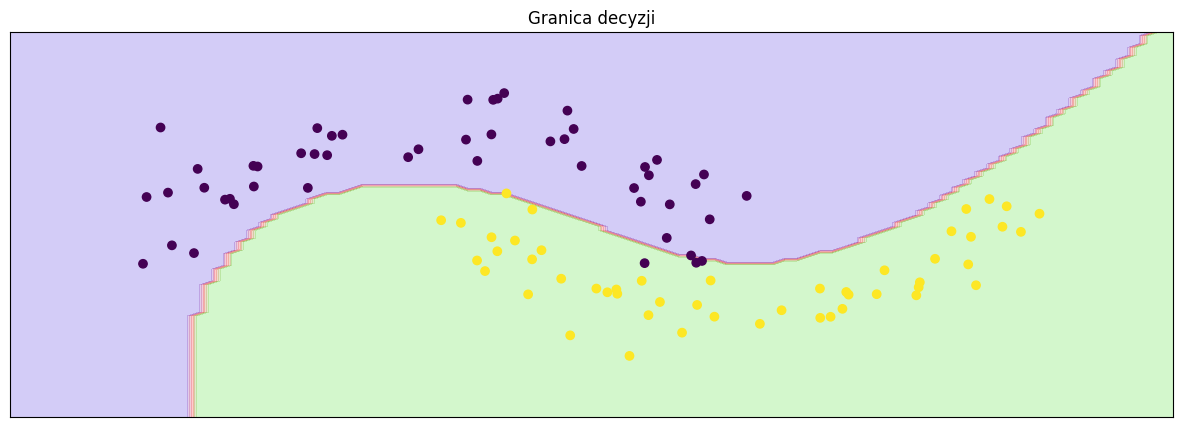

In [37]:
from helpers import plot_classifier

model = SVC(kernel='poly', coef0=1)
model.fit(x, y)
plot_classifier(x, y, model)

SVM z jądrami może sobie teraz poradzić także z problemem XOR. Wygenerujmy takie dane:

In [39]:
x = np.random.randn(200, 2)
y = np.logical_xor(x[:, 0] > 0, x[:, 1] > 0)

i wytrenuj klasyfikator. Spróbuj pozmieniać wartość kontrolującą złożoność hipotezy $C$ (nie jest to $c$ z funkcji jądra!).

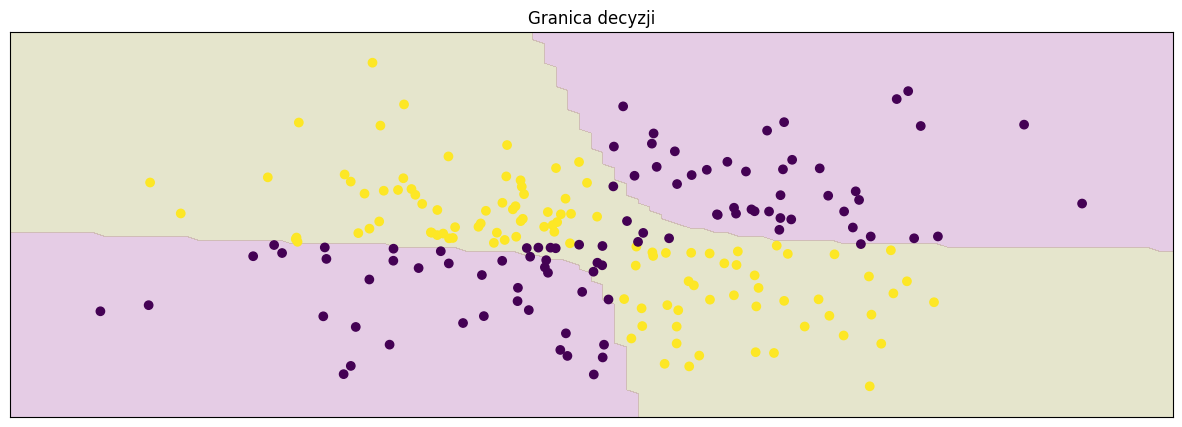

In [44]:
model = SVC(kernel='poly', coef0=0.5, degree=5)
model.fit(x, y)
plot_classifier(x, y, model)

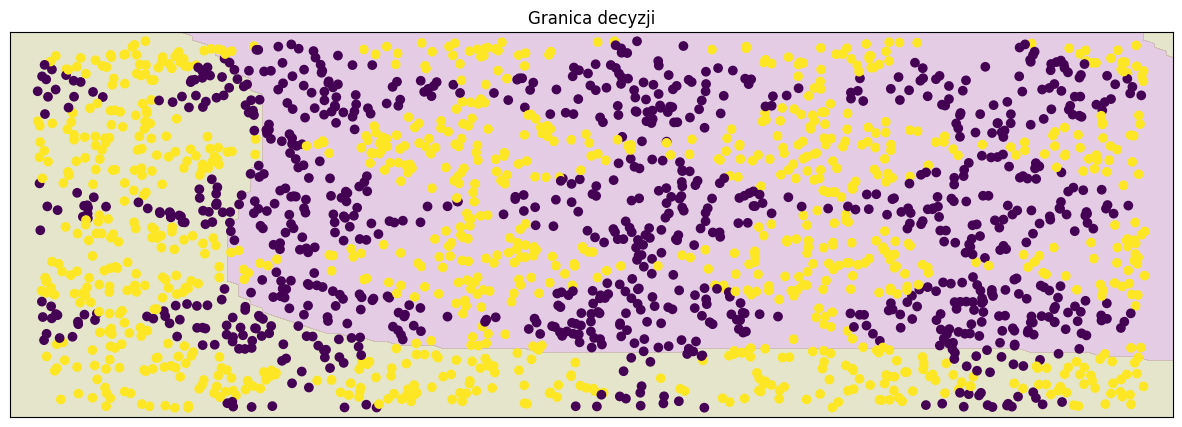

In [51]:
x = np.random.rand(2000,2)*20
y = np.sin(x[:,0])+np.sin(x[:,1])>0

model = SVC(kernel='poly', coef0=1)
model.fit(x, y)
plot_classifier(x, y, model)

Posteruj parametrami `degree` i `C` dla problemu XOR oraz wcześniejszego problemu klasyfikacji (dwa księżyce).

Prawdopodobnie najczęściej stosowaną funkcją jądrową jest jądro RBF (*Radial basis function kernel*) wyrażone wzorem:
$${\displaystyle K(\mathbf {x} ,\mathbf {x'} )=\exp(-\gamma \|\mathbf {x} -\mathbf {x'} \|^{2})}$$
który inaczej zapisany ${\displaystyle K(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)}$ przypomina wzór na rozkład normalny (przy $\gamma^{-1} = 2\sigma ^{2}$). Jego działanie możemy sobie wyobrazić jako stosowanie rozkładu normalnego, który jest wycentrowany na rozważanym przykładzie $\mathbf{x}$ do mierzenia podobieństwa z innymi przykładami. Przypisuje on najwyższe "prawdopodobieństwo" (wartość funkcji jądrowej) do naszej obserwacji $\mathbf{x}$ a im dalej od niej tym wartość spada. Jeśli więc inny przykład $\mathbf{x'}$ leży blisko $\mathbf{x}$ w przestrzeni cech to jądro odpowie wysoką wartością, im dalej tym odpowiedź będzie niższa. Z kształtu rozkładu normalnego wiemy też, ze po przekroczeniu pewnej odległości ($3\sigma$) jądro będzie odpowiadało zawsze (prawie) zerem. Szybkość opadania funkcji jądra reguluje właśnie parametr $\sigma$: im jest on wyższy, tym wariancja (szerokość) rozkładu jest wyższa, więc jądro wolniej spada. Innymi słowy przykłady mają "większy zakres oddziałowywawania" na inne przykłady. W kontekście jądra RBF przyjęło się sterować parametrem $\gamma$, który jak już podawałem wynika z podstawienia:
$$\gamma = \frac{1}{2\sigma ^{2}}$$
czyli im wyższe $\gamma$ (niższe $\sigma$) tym mniejszy zakres oddziałowywania, funkcja szybciej spada z odległością od przykładu i na odwrót. 

Niezwykłą ciekawostką dot. tej funkcji jądrowej jest to, że gdybyśmy zastanowili się jak wygląda przestrzeń cech które powinniśmy wygenerować aby dostać taki wynik bez użycia triku jądrowego to okazałoby się, że jest ich... nieskończenie wiele!

Jak pewnie się domyślasz, zastąpienie w konstruktorze `SVC` wyboru jądra na `kernel="rbf"` oraz podanie parametru `gamma` umożliwi ci przetestowanie SVM z jądrem RBF. 

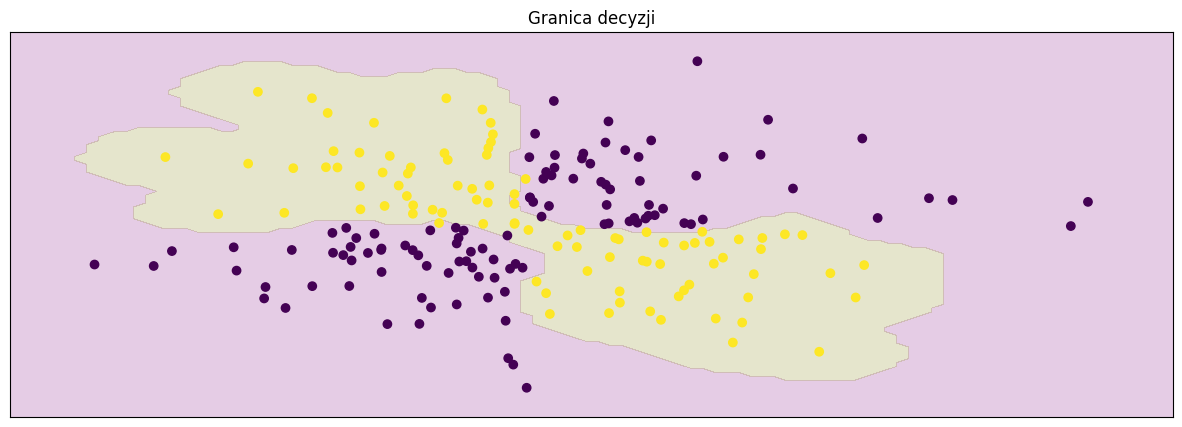

In [45]:
x = np.random.randn(200, 2)
y = np.logical_xor(x[:, 0] > 0, x[:, 1] > 0)


def plot_rbf(gamma: float) -> None:
    """Funkcja rysująca granicę decyzji klasyfikatora SVM z jądrem RBF.
    
    Args:
        gamma (float): Parametr gamma jądra RBF
        
    Returns:
        None
        
    """

    model = SVC(kernel='rbf', gamma=gamma)
    model.fit(x, y)
    plot_classifier(x, y, model)


plot_rbf(10)


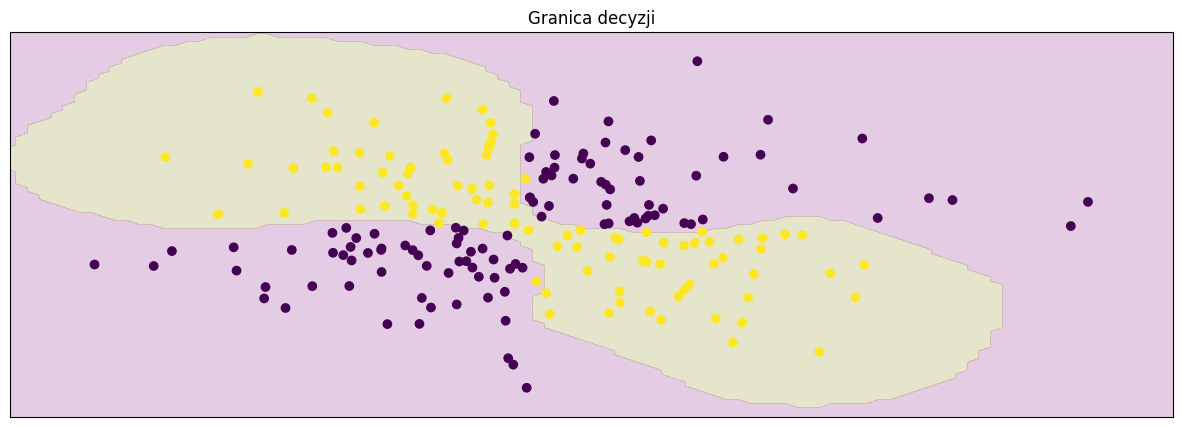

In [46]:
plot_rbf(2)

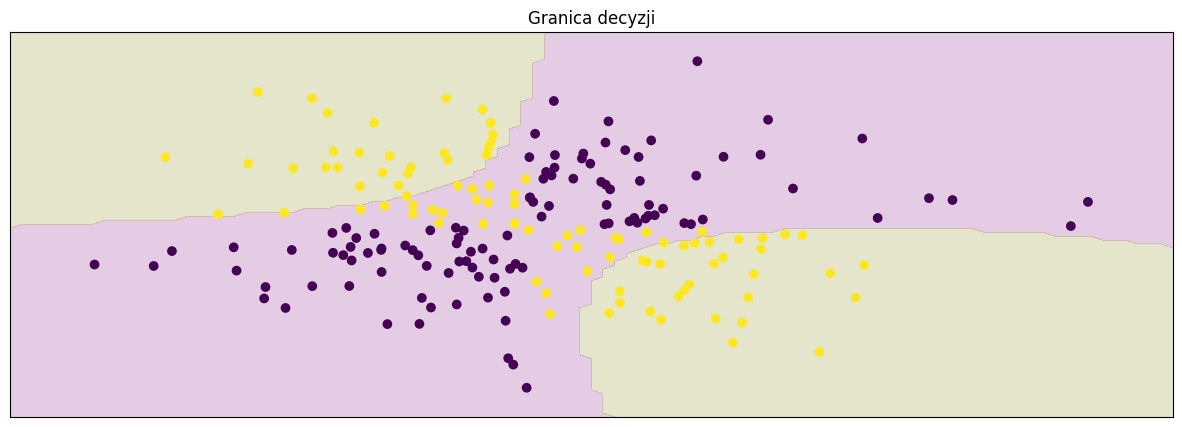

In [47]:
plot_rbf(0.1)

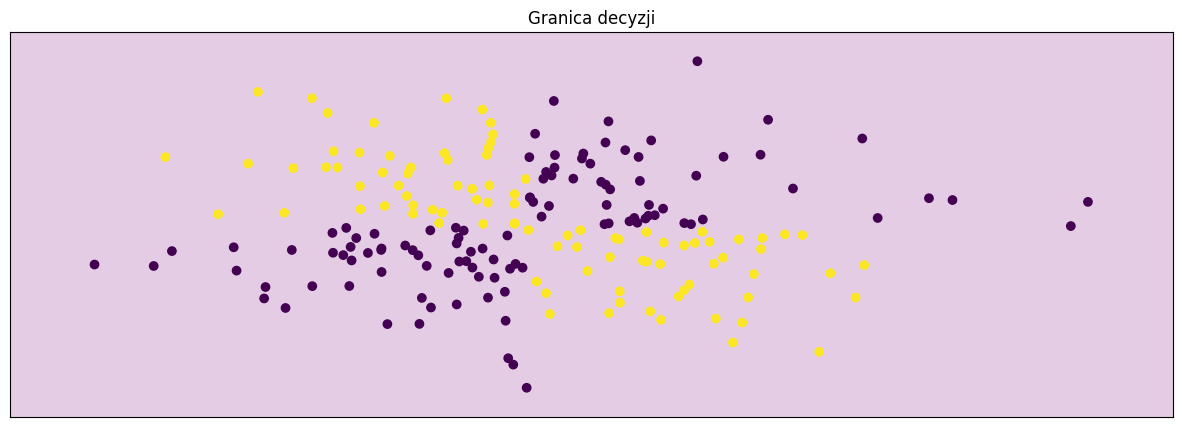

In [49]:
plot_rbf(0.01)

**Polecenia**: 
1. Przetesuj kilka wartości `gamma`. Rozważ przynajmniej wartości 0.01, 0.1, 1, 10.
2. Jakie wartości `gamma` powodują przeuczenie, a jakie niedouczenie?
3. Wczytaj poprzedni problem z dwoma księżycami i spróbuj dobrać `gamma`.
4. Wygeneruj zbiór z szachownicą
    ```
    x = np.random.rand(2000,2)*20
    y = np.sin(x[:,0])+np.sin(x[:,1])>0
    ```
    i spróbuj wybrać odpowiednio sparametryzowaną funkcję jądrową.

5. Czy klasyfikator SVM jest odporny na zmianę skali? Innymi słowy czy powinno się normalizować cechy przed jego użyciem? Dlaczego?
6. Jak myślisz czy dla każdego problemu (lub ew. prawie każdego) jest możliwe takie dobranie jądra np. wielomianowego aby zbiór był liniowo separowalny? Tj. byłoby w tej przestrzeni możliwe nauczenie klasyfikatora SVM z $C=\infty$? (Możesz spróbować, ale nie musisz)
7. Klasyfikator SVM jest binarny. Jak mógłbyś go użyć do klasyfikacji danych wieloklasowych?

Odpowiedź na punkty 2., 5. i 7. wpisz poniżej (krótkie konkretne odowiedzi wystarczą), dla reszty pozostaw kod w komórkach i ich wyniki jako dowód Twoich eksperymentów.

 # 2


- Małe wartości gamma (0,01) powodują niedouczenie - granica decyzji jest zbyt wygładzona i uproszczona, ignorująca lokalne struktury danych.
- Średnie wartości gamma (0,1-1) zapewniają dobry balans - granica jest elastyczna, ale zachowuje zdolność generalizacji.
- Wysokie wartości gamma (10) prowadzą do przeuczenia - granica dokładnie otacza pojedyncze punkty treningowe, tworząc izolowane obszary decyzyjne i tracąc zdolność generalizacji.

# 5

SVM nie jest odporny na zmianę skali i należy normalizować cechy przed jego użyciem, ponieważ:

- SVM bazuje na odległościach między punktami, więc cechy o większych wartościach będą miały nieproporcjonalnie duży wpływ
- Parametr regularyzacji C działa jednakowo na wszystkie cechy
- Jądra takie jak RBF, wykorzystujące odległość euklidesową, są szczególnie wrażliwe na różnice w skalach cech
- Parametr gamma w jądrze RBF działa nieefektywnie przy cechach o różnych skalach
- Bez normalizacji algorytm może faworyzować cechy o większej skali, niezależnie od ich rzeczywistej istotności


# 7

Binarny klasyfikator SVM można wykorzystać do problemów wieloklasowych stosując:
- Strategię One-vs-Rest - dla każdej klasy trenujemy osobny klasyfikator odróżniający ją od pozostałych. Nowy obiekt przypisywany jest do klasy z najwyższą wartością decyzyjną
- Strategię One-vs-One - trenujemy klasyfikator dla każdej pary klas. Klasyfikacja odbywa się przez głosowanie wszystkich klasyfikatorów


## Zadanie 4. - Wybór parametrów (za 20%)

Wygeneruj dane z szachownicą (takie same jak w zadanich wyżej)

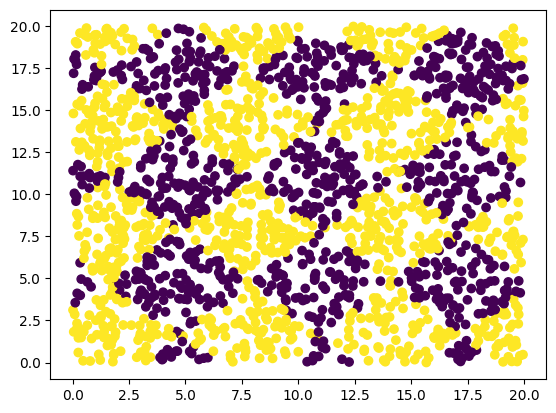

In [52]:
x = np.random.rand(2000, 2) * 20
y = np.sin(x[:, 0]) + np.sin(x[:, 1]) > 0
plt.scatter(x[:, 0], x[:, 1], c=y)

Spróbuj wybrać optymalne parametry dla klasyfikatora SVM z jądrem RBF (weź pod uwagę parametr `gamma` jądra i parametr `C`). Przykładową techniką poszukiwania dobrych parametrów jest zdefiniowanie tzw. siatki parametrów i sprawdzenie wszystkich możliwości. W pierwszym kroku musimy ustalić siatkę czyli np. dla parametru `gamma` będziemy testować wartości 0.1, 1, 10, a dla parametru `C` wartości 1 i 10. Poszukiwanie gridowe dla takiej siatki uruchomi proces uczenia 6 razy, zewaluuje trafność i zwróci najlepsze parametry. Ewaluacja trafności może się odbywać np. walidacją krzyżową, a w `sklearn` jest to zaimpementowane w obiekcie `GridSearchCV`.

Pierwszym argumentem konstruktora obiektu `GridSearchCV` jest obiekt klasyfikatora, a kolejne ważne parametry to ` param_grid= słownik z siatką`, `scoring='accuracy'` (aby była ewaluowana trafność). Dodatkowo można ustawić `verbose=2` jeśli chcesz, żeby pojawiły się na konsoli dodatkowe informacji o uczeniu kolejnych klasyfikatorów oraz parametrem `cv=` kontrulującym na ile cześci powinien zostać podzielony zbiór uczący w trakcie walidacji krzyżowej. Np.
```
GridSearchCV(KLASYFIKATOR, param_grid= PARAMETRY scoring='accuracy', verbose=2, cv=3)
```
Siatkę `PARAMETRY` definiujemy poprzez podanie słownika, którego kluczami są nazwy parametrów klasyfikatora, a wartościami są listy wartości do sprawdzenia np. `{'gamma':[0.1,1,10], 'C':[1,10]}`. `GridSearchCV` uruchamiamy standardowo czyli porzez funkcję `fit()`. 

Znajdź dobre ustawienia klasyfikatora SVM z jądrem RBF dla problemu z szachownicą.

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(kernel='rbf')
params = dict(gamma=[0.1, 1, 10], C=[1, 10])
grid = GridSearchCV(model, param_grid=params, scoring='accuracy', cv=3, n_jobs=4)
grid.fit(x, y)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=4,
             param_grid={'C': [1, 10], 'gamma': [0.1, 1, 10]},
             scoring='accuracy')

Przyjrzyj się wynikowi - właściwość `GRID.best_params_`

In [54]:
grid.best_params_

{'C': 10, 'gamma': 0.1}

Oraz szczegółom przeszukiwania - właściwość `GRID.cv_results_`

In [55]:
grid.cv_results_

{'mean_fit_time': array([0.15825391, 0.15294663, 0.47782882, 0.1328253 , 0.12856261,
        0.44727453]),
 'std_fit_time': array([0.02657049, 0.00996284, 0.01577763, 0.01488371, 0.01580929,
        0.00943204]),
 'mean_score_time': array([0.1776801 , 0.16346876, 0.37988631, 0.11618408, 0.09104005,
        0.33951648]),
 'std_score_time': array([0.00834608, 0.02743599, 0.0276765 , 0.01092876, 0.00495331,
        0.00186764]),
 'param_C': masked_array(data=[1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'param_gamma': masked_array(data=[0.1, 1.0, 10.0, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'C': 1, 'gamma': 0.1},
  {'C': 1, 'gamma': 1},
  {'C': 1, 'gamma': 10},
  {'C': 10, 'gamma': 0.1},
  {'C': 10, 'gamma': 1},
  {'C': 10, 'gamma': 10}],
 'split0_test_score': array([0.89355322, 0.91454273, 0.91604198, 0.92053973, 0.92053973,
        0.91904

Wytrenuj klasyfikator z najlepszymi znalezionymi parametrami i zwizualizuj go `plot_classifier`.

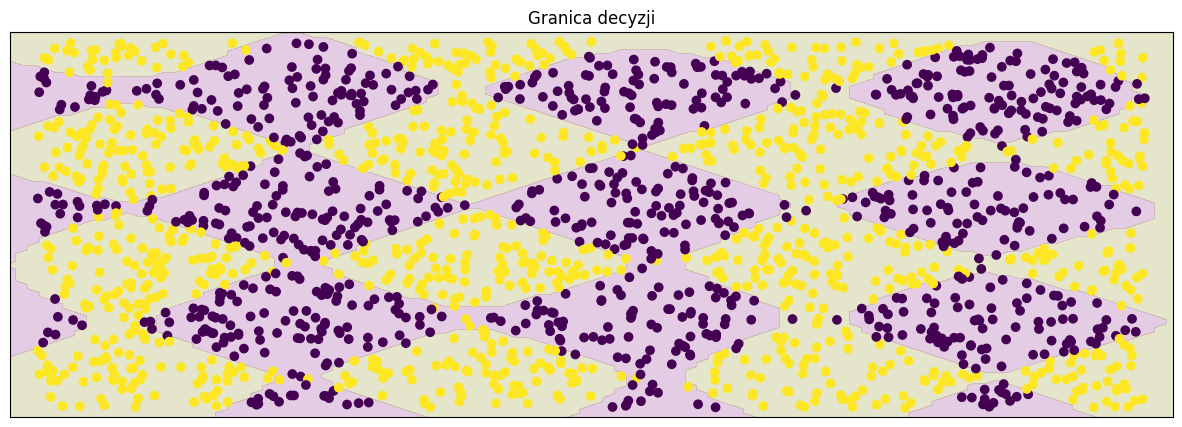

In [56]:
model = SVC(kernel='rbf', **grid.best_params_)
model.fit(x, y)
plot_classifier(x, y, model)

**Polecenia**
1. Typ funkcji jądrowej może być jednym z parametrów które stroimy. Jednak różne funkcje jądrowe mają różne parametry - jak to wyspecyfikować? Zobacz fragment [dokumentacji sekcja 3.2.1 ](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search), który pokazuje jak to zrobić. Rozszerz twoje przeszukiwanie o jądra liniowe i wielomianowe.
2. Spróbuj strojenia na innym wybranym zbiorze.
3. Czy wynik uzyskany przez GridSearchCV jest dobrą estymacją trafności na zbiorze testowym?

Odpowiedź na punkt 3. poniżej.

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np

from helpers import get_wine

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])

param_grid = [
    # Parametry dla jądra liniowego
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 1, 10, 100]
    },
    # Parametry dla jądra wielomianowego
    {
        'svm__kernel': ['poly'],
        'svm__C': [0.1, 1, 10],
        'svm__degree': [2, 3, 4],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
    },
    # Parametry dla jądra RBF
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
    }
]

# Przeszukiwanie siatki
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

X, y = get_wine()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu
grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność (CV):", grid_search.best_score_)

# Ewaluacja na zbiorze testowym
y_pred = grid_search.predict(X_test)
print("Dokładność na zbiorze testowym:", accuracy_score(y_test, y_pred))

# Wizualizacja wyników
if X.shape[1] == 2:
    from helpers import plot_classifier
    plot_classifier(X, y, grid_search.best_estimator_)

Fitting 5 folds for each of 73 candidates, totalling 365 fits
Najlepsze parametry: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Najlepsza dokładność (CV): 0.9967291034278523
Dokładność na zbiorze testowym: 0.9953846153846154


# 3

Nie. Wynik GridSearchCV przeszacowuje rzeczywistą trafność modelu na nowych danych. Dzieje się tak, bo ta sama procedura walidacji krzyżowej jest używana zarówno do wyboru najlepszych parametrów, jak i do oceny wybranego modelu. Przez wielokrotne testowanie różnych kombinacji parametrów zwiększamy szansę na przypadkowe dopasowanie do specyficznych cech zbioru walidacyjnego. Aby uzyskać wiarygodną ocenę, należy użyć całkowicie niezależnego zbioru testowego, który nie był wykorzystany podczas procesu doboru parametrów.

## Zadanie 5. - SVM dla dużych danych (za 20%)

In [59]:
from helpers import get_wine

x, y = get_wine()

Metoda maszyn wektorów podpierających ma wiele zalet. Po pierwsze tworzy modele z dość małą liczbą wektorów podpierających które determinują wielkość nauczonego modelu. Dodatkowo faza predykcji jest bardzo szybka. Ponieważ uczenie jest zależne tylko od kilku, automatycznie wybieranych, wektorów podpierających, a resztę zbioru danych można by usunąć bez zmiany wyindukowanego klasyfikatora to wynik SVM zwykle zależy od małego podzbioru zbioru uczącego. SVM dobrze sobie radzą nawet w sytuacji gdy liczba przykładów jest dalece mniejsza niż liczba cech! (Przypomnij sobie co się wtedy dzieje z regresją liniową). Dodatkowo, pomimo tego że SVM jest klasyfikatorem liniowym to zastosowanie triku jądrowego pozwala na indukcje płaszczyzny separującej w rozszerzonej przestrzeni. Ponadto trik jądrowy pozwala na tworzenie własnych jąder dostosowanych do dziedziny problemu (tak jak w kNN mogliśmy projektować funkcje odległości) co spowodowało  szerokie ich wykorzystanie w tekstach czy obrazach (istnieją gotowe funkcje jądrowe nawet do przetwarzania grafów).

Jeśli chodzi o najważniejsze wady tego klasyfikatora to pierwszą dużą wadą jest konieczność strojenia parametrów funkcji jądrowych oraz parametru $C$. Jednakże w świetle powszechnego korzystania z sieci neuronowych, które wymagają strojenia znacznie większej liczby parametrów (architektura, różne dodatkowe triki) nie wiem czy nadal powinno się to uważać za  wadę nie do przeskoczenia. Druga wada SVM jest jednak znaczenie gorsza: koszt obliczeniowy uczenia. Rozwiązywanie problemu programowania kwadratowego definiowanego przez SVM jest rzędu sześciennego od liczby przykładów $\mathcal{O}[n^3]$ czy dla efektywniejszych implementacji $\mathcal{O}(\max(n,d) \min (n,d)^2)$  - nadal jest to bardzo kosztowne obliczeniowo.

Jednakże na ten drugi problem możemy rozwiązać za pomocą algorytmów w rodzaju stochastycznego spadku wzdłuż gradientu! Funkcja celu która jest optymalizowana przez SVM nazywamy funkcją zwiasową (*hinge loss*) i jest ona ekwiwalentna z prymalną postacią problemu. Jednak to właśnie jego postać dualna umożliwiała zastosowanie triku jądrowego. Aby więc zastosować SGD trzeba by rzeczywiście przeskalować zbiór uczący do przestrzeni cech definiowanej przez jądro (ona może mieć nawet $\infty$ liczbę wymiarów!). Na szczęście tak jak SGD używa przybliżonej estymacji gradientu tak samo możemy użyć *przybliżonej* transformacji jądrowej. Jedną z takich technik jest aproksymacja Nyströma, która wychodzi z założenia że macierz jądrowa jest rzędu $m$ dalece mniejszego od $n$. Zakłada się więc, że mając tylko wiedzę o $m$ wierszach macierzy jądrowej można zrekonstruować ją całą. W praktyce nie jest to prawda, ale po prostu mamy nadzieję, że $n-m$ najmniejszych wartości własnych jest na tyle małe że i tak uzyskujemy dobrą aproksymację (patrz: Materiały dla chętnych).

Wytrenuj na wczytanych danych SVM poprzez algorytm SGD - obiekt `SGDClassifier`. Pamiętaj o wyspecyfikowaniu zawiasowej funkcji straty `loss='hinge'`. Dodatkowo, aby wykonać trik jądrowy przetransformuj dane wejściowe aprokymacją Nyströma (obiekt `Nystroem`). Parametry tego obiektu to `kernel` (ustawmy RBF) oraz `gamma` (dla RBF), a także ` n_components` czyli ile wektorów używanych jest do przybliżenia jądra (domyślnie 100 i do naszych celów jest to wystarczające).

In [60]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2)
nyst = Nystroem(kernel='rbf', n_components=100)
x_tr_nyst = nyst.fit_transform(x_tr)
x_te_nyst = nyst.fit_transform(x_te)

Porównaj czas uczenia na tych samych danych modelu `SVC` oraz modelu przybliżonego (`Nystroem`+`SGD`). Czas wykonania komórki kodu możesz przetestować poprzez dodanie do niej na początku znacznika 
`%%timeit`.

In [61]:
%%timeit
model = SVC(kernel='rbf')
model.fit(x_tr, y_tr)

767 ms ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%%timeit
model = SGDClassifier(loss='hinge')
model.fit(x_tr_nyst, y_tr)

107 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Polecenia**
1. Zwiększ rozmiar zbioru pięciokrotnie (kopiując przykłady). Jak teraz wygląda czas uczenia klasyfikatora  obiema metodami?
2. Porównaj trafności obydwu metod na zbiorze uczącym i testowym.
3. Spróbuj przeskalować dane uczące przed użyciem obydwu metod np. metodą Min-Max
   ```
   from sklearn.preprocessing import MinMaxScaler
   scaler = MinMaxScaler()
   ```
   Jak zmienił się czas uczenia? Jak zmieniła się trafność modelu?

4. Przetestuj różne wartości `n_components` transformacji przybliżonej. Spróbuj zaobserwować zależności pomiędzy trafnością modelu a modelem referencyjnym (bez przybliżenia). Możesz też spróbować porównać czasy uczenia dla kliku wielkości `n_components`.

Zostaw kod w komórkach i ich wyniki na dowód Twoich eksperymentów.

(MIEJSCE NA TWOJE ODPOWIEDZI)